## Cultura general

### PPO(Proximal Policy Optimization)

Es una técnica derivada de los **Policy gradient methods** muy utiliza en aprendizaje por refuerzo profundo. 

Esta técnica ha ganado mucha popularidad a la hora de crear **videojuegos** o **procesamiento en 3D**, el cual destaca por su sensibilidad en cada "step" o etapa para poder adaptarse a los cambios de una manera más efectiva y también busca protegerse ante el ruido que pueda provocar algún tipo de incertidumbre o catástrofe.

La mejora que obtiene ante otro tipo de modelos similares a sus función de coste, la cual le permite llegar de una manera más rápida y efectiva al gradiente. Consiguiendo resultado increíbles y en un menor tiempo que otro tipo de aprendizaje por refuerzo.

Para más información sobre sus ventajas dejo la pagina de [OpenAI](https://openai.com/research/openai-baselines-ppo), donde explican con más detalle sus ventajas.

### Función de coste

$$
L^{CLIP}(\theta) = \mathbb{E}^t \left[ \min \left( r_t(\theta) A_t, \text{clip}\left( r_t(\theta), 1 - \epsilon, 1 + \epsilon \right) A_t \right) \right]
$$


$$
\text{Donde:} \\
L^{CLIP}(\theta) \text{ es la función objetivo que se optimiza en el algoritmo PPO.} \\
\mathbb{E}^t \text{ denota la esperanza condicional sobre las trayectorias del tiempo } t. \\
r_t(\theta) \text{ es el ratio entre las probabilidades de acción bajo la política actual y la anterior.} \\
A_t \text{ es la ventaja del estado-acción } (s_t, a_t) \text{ en el paso de tiempo } t. \\
\epsilon \text{ es un hiperparámetro que controla el tamaño del clipping.} \\
\text{clip}(x, a, b) \text{ es una función que limita } x \text{ entre } a \text{ y } b.
$$


En resumen, PPO es una opción atractiva para el trading debido a su estabilidad, eficiencia computacional y capacidad para equilibrar la exploración y la explotación en entornos volátiles como los mercados financieros.

## Librerias necesarias

In [1]:
# %pip install ipywidgets
# %pip install gymnasium
# %pip install stable-baselines3[extra]
# %pip install -U lib-pybroker
# %pip install numpy
# %pip install matplotlib
# %pip install pandas

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt 
from pybroker import YFinance
import pybroker
pybroker.enable_data_source_cache('yfinance')

## Funciones auxiliares

In [2]:
def dataset_loader(stock_name,start_date,end_date):
    yfinance = YFinance()
    df = yfinance.query([stock_name], start_date=start_date, end_date=end_date)
    df['date'] = pd.to_datetime(df['date']).dt.date
    return df

In [3]:
def render_all(df,title):
    df = df.set_index('Date')       
    fig, ax = plt.subplots(figsize=(18, 6)) 
    df.plot( y="market_value" , use_index=True,  ax = ax, style='--' , color='lightgrey',label="valor de mercado") 
    df.plot( y="price" , use_index=True,  ax = ax , secondary_y = True , color='black', label= "precio de la acción", title=title)

    for idx in df.index.tolist():
        if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['amount'] > 0):
            plt.plot(
                idx,
                df.loc[idx]["price"] - 1,
                'g^'
            )
            plt.text(idx, df.loc[idx]["price"]- 3, df.loc[idx]['amount'] , c= 'green',fontsize=8, horizontalalignment='center', verticalalignment='center')
        elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['amount'] > 0):
            plt.plot(
                idx,
                df.loc[idx]["price"] + 1,
                'rv'
                )
            plt.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['amount'], c= 'red',fontsize=8, horizontalalignment='center', verticalalignment='center') 

## Crear un bot de trading basado en el entorno de OpenAI GYM 

OpenAI GYM es un entorno especializado en trading, ayudándonos a tener en cuenta más valores y comparar su rendimiento entre los distintos algoritmos de una manera sencilla. 

En su web encontramos un montón de [tutoriales](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py) para crear entornos para un montón de funcionalidades, Como vamos a usar entrenamiento por refuerzo **(deep reinforcement learning)** vamos a utilizar **stable-baselines3** que es el entorno para desarrollar este tipo de algoritmos. Por tanto vamos a utilizar como [interfaz](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html) para nuestra clase el entorno de **stable-baselines3** basado en **PPO**.

In [4]:
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, commission_fee=0.01, slippage_cost=0.1):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.date = data['date']
        self.stock_price_history = data['adj_close']
        self.commission_fee = commission_fee
        self.slippage_cost = slippage_cost
        
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,))  #*Creamos un espacio de actuación donde: -1: Comprar, 0: Mantener, 1: Vender
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))
        
        self.render_df = pd.DataFrame()
        self.done = False
        self.current_portfolio_value = initial_balance
        
    def reset(self, seed = None):
        """Función de reinicio: utilizamos para reiniciar el aprendizaje cuando se llega al objetivo

        Args:
            seed (Any, optional): Semilla para evitar la aleatoriedad del proceso. Por defecto None.

        Returns:
            list: mapa del contexto reiniciado para el entrenamiento
        """
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.done = False
        self.current_portfolio_value = self.initial_balance
        return self._get_observation(), {}
    
    def step(self, action):
        """Función que realiza la acción elegida y actualiza los beneficios del portfolio y el tablero del modelo.

        Args:
            action (space): Acción a realizar con los datos obtenidos

        Returns:
            List: devolvemos el tablero, recompensas, si hemos finalizado y lo relativo a 
        """
        assert self.action_space.contains(action)
        #*Calculamos el valor previo a que se realice una acción
        prev_portfolio_value = self.balance if self.current_step == 0 else self.balance + self.stock_owned * self.stock_price_history[self.current_step - 1]
        current_price = self.stock_price_history[self.current_step]    
        amount = int(self.initial_balance * action[1] / current_price)
    
        if action[0] > 0:  #* Comprar
            amount =  min( int(self.initial_balance * action[1] / current_price), int(self.balance / current_price * (1 + self.commission_fee + self.slippage_cost)))
            if self.balance >= current_price * amount * (1 + self.commission_fee + self.slippage_cost):
                self.stock_owned += amount
                self.balance -= current_price * amount * (1 + self.commission_fee + self.slippage_cost)
        elif action[0] < 0:  #* Vender
            amount = min(amount, self.stock_owned)
            if self.stock_owned > 0:
                self.stock_owned -= amount
                self.balance += current_price * amount * (1 - self.commission_fee - self.slippage_cost)
        
        #* Calculamos el valor que tenemos después de realizar la acción
        current_portfolio_value = self.balance + self.stock_owned * current_price
        excess_return = current_portfolio_value - prev_portfolio_value 
        risk_free_rate = 0.02  #* El ratio de riesgo permitido lo utilizamos para calcular la efectividad de la acción
        std_deviation = np.std(self.stock_price_history[:self.current_step + 1])
        sharpe_ratio = (excess_return - risk_free_rate) / std_deviation if std_deviation != 0 else 0 #*Calculamos la efectividad de la acción
        reward = sharpe_ratio #* Lo recompensamos según su efectividad
         
        self.render(action, amount, current_portfolio_value)
        obs = self._get_observation()
        
        self.current_step += 1
        
        if self.current_step == len(self.data['adj_close']):
            done = True
        else:
            done = False
        
        self.done = done

        info = {}  
        return obs, reward, done, False,info
    
    
    def _get_observation(self):
        return np.array([
            self.stock_price_history[self.current_step]
        ])
    
    def render(self, action, amount, current_portfolio_value, mode = None):
        current_date = self.date[self.current_step]
        today_action =  'buy' if action[0] > 0 else 'sell'
        current_price = self.stock_price_history[self.current_step]
        
        if mode == 'human':
            print(f"Step:{self.current_step}, Date: {current_date}, Market Value: {current_portfolio_value:.2f}, Balance: {self.balance:.2f}, Stock Owned: {self.stock_owned}, Stock Price: {current_price:.2f}, Today Action: {today_action}:{amount}")
        else:
            pass
        dict = {
            'Date': [current_date], 'market_value': [current_portfolio_value], 'balance': [self.balance], 'stock_owned': [self.stock_owned], 'price': [current_price], 'action': [today_action], 'amount':[amount]
        }
        step_df = pd.DataFrame.from_dict(dict)
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)


## Entrenamiento

Para entrenar el modelo usaremos las acciones de apple desde el 2019 hasta el 2023 dejando el restante para que prediga.

Le daremos: **100000$** de **balance** inicial, una **comisión** del **1%** y una **desviación** del **5%**

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
import pandas as pd

import time

start_date = '3/1/2019'
end_date = '3/1/2023'
year = start_date.split("/")[2]
stock_name = "AAPL"
df = dataset_loader(stock_name, start_date, end_date)

#*Creamos en el entorno de partida
def make_env(df, initial_balance=100000, commission_fee=0.001, slippage_cost=0.005):
    def _fn():
        env = StockTradingEnv(df.copy(), initial_balance, commission_fee, slippage_cost)
        return env
    return _fn

#*Numero de entornos virtuales a crear 
#!No superar la cantidad de hilos del procesador
n_envs = 16  

#*Creamos el entorno vectorizado
env = SubprocVecEnv([make_env(df.copy()) for _ in range(n_envs)])  #*Creamos instancias para cada entorno


model = PPO("MlpPolicy", env, verbose=0, device="cpu")
model.learn(total_timesteps=10_000*n_envs, progress_bar=True) #*Ponemos la cantidad de episodios en base a los entornos que tengamos  
model.save(f"ppo_{stock_name.lower()}_{year}")

Loaded cached bar data.



Output()

## Validación

Para la validación usaremos las acciones de apple desde 2023 hasta el 2024 para ver cual sería el flujo de decisiones y compararlo con la realidad.

Usaremos el mismo entorno que en el entrenamiento: **100000$** de **balance** inicial, una **comisión** del **1%** y una **desviación** del **5%**

Loading bar data...


[*********************100%%**********************]  1 of 1 completed

Loaded bar data: 0:00:01 



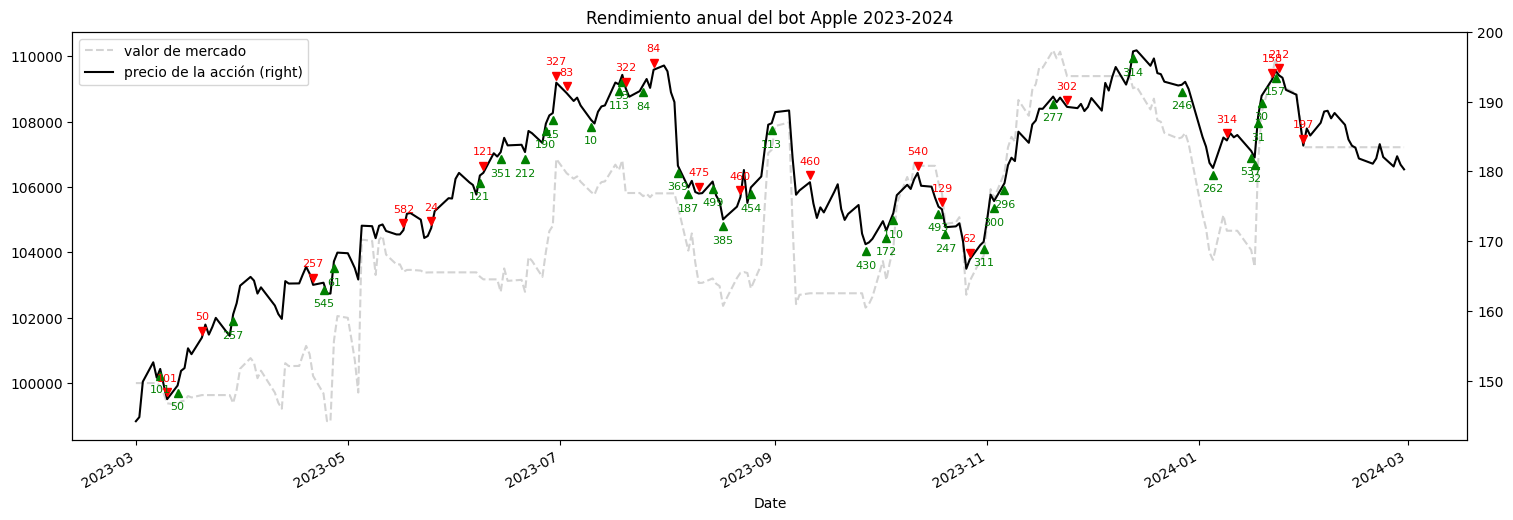

In [6]:
yfinance = YFinance()
start_date = '3/1/2023'
end_date = '3/1/2024'
df = yfinance.query([stock_name], start_date=start_date, end_date=end_date)
df['date'] = pd.to_datetime(df['date']).dt.date
env = StockTradingEnv(df, initial_balance=100000, commission_fee=0.001, slippage_cost=0.005)

#* Cargamos nuestro modelo con las variables de entorno elegidas
model = PPO.load(f"ppo_{stock_name}_{year}",env=env)

vec_env = model.get_env()
values = []
size = 10
market_value = 0
for _ in range(size):
    obs = vec_env.reset()
    for i in range(len(df['adj_close'])):
        action, _state = model.predict(obs)
        obs, reward, done, info = vec_env.step(action)
        
    #* Si tenemos una mayor cuota de mercado guardamos su gráfica para dibujarla
    if market_value < env.render_df.market_value.iloc[-1]:
        market_value = env.render_df.market_value.iloc[-1]
        df_fn = env.render_df
        df_fn['Date'] = pd.to_datetime(df_fn['Date'])
        #* Filtrar para seleccionar las filas dentro del rango de fechas deseado
        date_filter = (df_fn['Date'] >= start_date) & (df_fn['Date'] <= end_date)
        df_fn = df_fn[date_filter]

        #* Eliminar los demás rangos para quedarnos con el mayor
        df_fn = df_fn.drop_duplicates(subset=['Date'], keep='last')


    values.append(env.render_df.market_value.iloc[-1])

render_all(df_fn,"Rendimiento anual del bot Apple 2023-2024")

Podemos observar que el modelo predice bastante ajustado a la realidad tomando buenas decisiones tanto a la hora de comprar como vender.

En base al ratio de riesgo-recompensa que le hemos dado podemos observar la cantidad que vende y comprar donde suele ser mayor cuanto más "seguro" sea la acción.

In [7]:
average_profit = (((np.sum(values)/size)-env.initial_balance)/env.initial_balance)*100
max_profit = ((max(values)-env.initial_balance)/env.initial_balance)*100
min_profit = ((min(values)-env.initial_balance)/env.initial_balance)*100
first_price = df_fn.price.iloc[0]
last_price = df_fn.price.iloc[-1]

hold_price = ((last_price-first_price)/first_price)*100

print(f"Mayor beneficio: {max_profit:.2f}%\nMínimo beneficio: {min_profit:.2f}%\nMedia de beneficio: {average_profit:.2f}%\nValor de hold: {hold_price:.2f}%")

#*Guardar los resultados en un fichero
with open("test.txt", "a") as f:
    f.write(f"\n{year}-{stock_name}:\nMayor beneficio: {max_profit:.2f}%\nMínimo beneficio: {min_profit:.2f}%\nMedia de beneficio: {average_profit:.2f}%\nValor de hold:{hold_price:.2f}%")

Mayor beneficio: 7.21%
Mínimo beneficio: -11.21%
Media de beneficio: -1.49%
Valor de hold: 25.05%


## Pruebas en BITCOIN-DOLAR (BTC-USD)

Para este caso necesitaremos 1.000.000$ de balance para conseguir mejor resultado dado el valor del BTC

In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
import pandas as pd

import time

start_date = '3/1/2016'
end_date = '3/1/2023'
year = start_date.split("/")[2]
stock_name = "BTC-USD"
df = dataset_loader(stock_name, start_date, end_date)

#*Creamos en el entorno de partida
def make_env(df, initial_balance=1000000, commission_fee=0.001, slippage_cost=0.005):
    def _fn():
        env = StockTradingEnv(df.copy(), initial_balance, commission_fee, slippage_cost)
        return env
    return _fn

#*Numero de entornos virtuales a crear 
#!No superar la cantidad de hilos del procesador
n_envs = 16  

#*Creamos el entorno vectorizado
env = SubprocVecEnv([make_env(df.copy()) for _ in range(n_envs)])  #*Creamos instancias para cada entorno


model = PPO("MlpPolicy", env, verbose=0, device="cpu")
model.learn(total_timesteps=10_000*n_envs, progress_bar=True) #*Ponemos la cantidad de episodios en base a los entornos que tengamos  
model.save(f"ppo_{stock_name.lower()}_{year}")

Loading bar data...


[*********************100%%**********************]  1 of 1 completed

Loaded bar data: 0:00:00 



Output()

Loaded cached bar data.



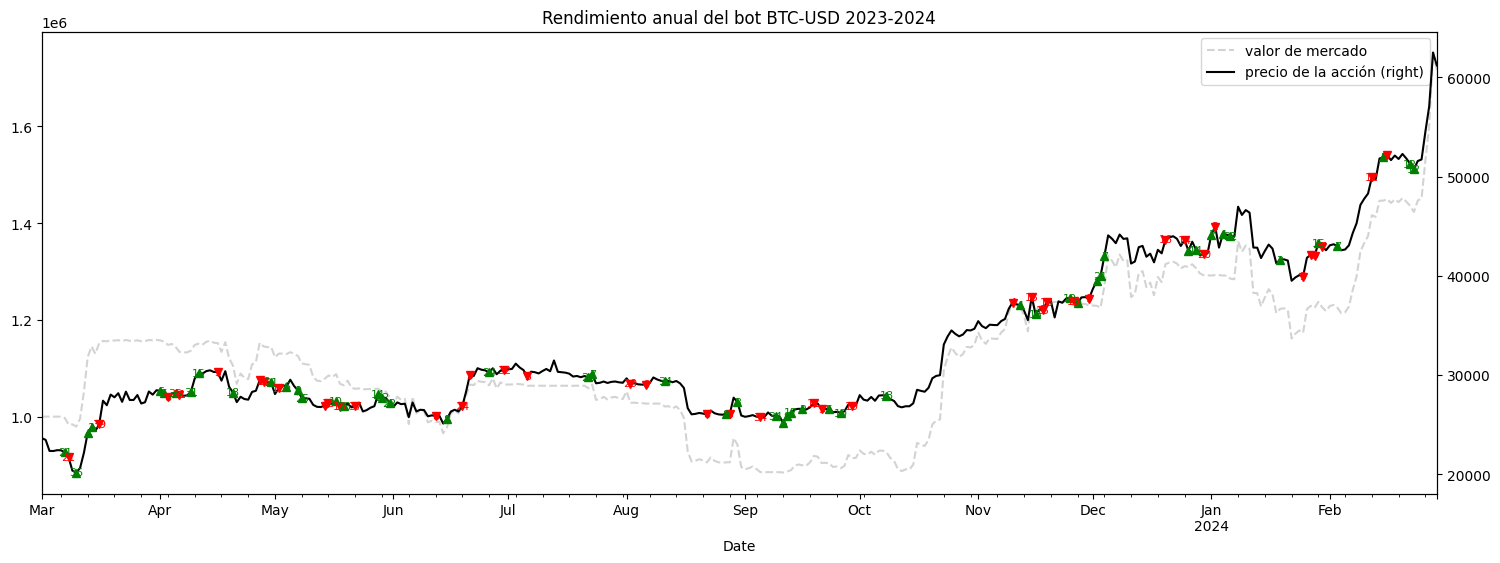

In [15]:
yfinance = YFinance()
start_date = '3/1/2023'
end_date = '3/1/2024'
df = yfinance.query([stock_name], start_date=start_date, end_date=end_date)
df['date'] = pd.to_datetime(df['date']).dt.date
env = StockTradingEnv(df, initial_balance=1000000, commission_fee=0.001, slippage_cost=0.005)

#* Cargamos nuestro modelo con las variables de entorno elegidas
model = PPO.load(f"ppo_{stock_name}_{year}",env=env)

vec_env = model.get_env()
values = []
size = 10
market_value = 0
for _ in range(size):
    obs = vec_env.reset()
    for i in range(len(df['adj_close'])):
        action, _state = model.predict(obs)
        obs, reward, done, info = vec_env.step(action)
        
    #* Si tenemos una mayor cuota de mercado guardamos su gráfica para dibujarla
    if market_value < env.render_df.market_value.iloc[-1]:
        market_value = env.render_df.market_value.iloc[-1]
        df_fn = env.render_df
        df_fn['Date'] = pd.to_datetime(df_fn['Date'])
        #* Filtrar para seleccionar las filas dentro del rango de fechas deseado
        date_filter = (df_fn['Date'] >= start_date) & (df_fn['Date'] <= end_date)
        df_fn = df_fn[date_filter]

        #* Eliminar los demás rangos para quedarnos con el mayor
        df_fn = df_fn.drop_duplicates(subset=['Date'], keep='last')


    values.append(env.render_df.market_value.iloc[-1])

render_all(df_fn,"Rendimiento anual del bot BTC-USD 2023-2024")

En el bitcoin sin embargo, al tratarse de una acción más a la alza tiende a realizar un mayor número de operaciones. Dándonos un buen resultado con respecto al valor de hold.

In [16]:
average_profit = (((np.sum(values)/size)-env.initial_balance)/env.initial_balance)*100
max_profit = ((max(values)-env.initial_balance)/env.initial_balance)*100
min_profit = ((min(values)-env.initial_balance)/env.initial_balance)*100
first_price = df_fn.price.iloc[0]
last_price = df_fn.price.iloc[-1]

hold_price = ((last_price-first_price)/first_price)*100

print(f"Mayor beneficio: {max_profit:.2f}%\nMínimo beneficio: {min_profit:.2f}%\nMedia de beneficio: {average_profit:.2f}%\nValor de hold: {hold_price:.2f}%")

#*Guardar los resultados en un fichero
with open("test.txt", "a") as f:
    f.write(f"\n{year}-{stock_name}:\nMayor beneficio: {max_profit:.2f}%\nMínimo beneficio: {min_profit:.2f}%\nMedia de beneficio: {average_profit:.2f}%\nValor de hold:{hold_price:.2f}%")

Mayor beneficio: 71.64%
Mínimo beneficio: -20.32%
Media de beneficio: 26.85%
Valor de hold: 158.80%


Como conclusión, observamos un mayor nivel de beneficios con el modelo entrenado por acciones más a la alza, también los resultados utilizando los PPO son bastante mejores en comparación al uso del método de aprendizaje por refuerzo tradicional.

Podríamos obtener mejores resultados ajustando el nivel de riesgo o añadiendo otro tipos de parámetros que ayuden a predecir cada tipo de acción en concreto. También he podido observar que el modelo se vuelve más estable cuanto mayor el número de etapas de entrenamiento, llegando a tomar opciones de hold en acciones que den beneficio directo.